In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from findthegap.gapper import Gapper
import torch

%matplotlib inline

In [2]:
d=np.load('/users/caganze/streams_data.npy',  allow_pickle=True).flatten()[0]

In [3]:
d.keys()

dict_keys(['bckgd', 'stream', 'streamgap'])

In [4]:
def get_density(data, padding=1.5, bw=0.7, nboot=2):
    n=50
    padding=padding
    x_to_y= np.ptp(data[:,0])/ np.ptp(data[:,1])
    bounds = np.array([[np.min(data[:,d]),np.max(data[:,d])] for d in range(data.shape[1])])
    gridding_size = [ n,int( n/(x_to_y))]
    grid_linspace = [ np.linspace(bounds[d][0]+padding, bounds[d][1]-padding, gridding_size[d]) for d in range(2) ]
    meshgrid = np.meshgrid(*grid_linspace, indexing='ij')

    meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in meshgrid]
    grid_data = np.hstack(meshgrid_ravel)
    
    g=Gapper(data, bw, bounds=bounds)
    
    dens=g.get_density(torch.tensor(grid_data),  requires_grad=False).reshape((gridding_size[0], gridding_size[1]))
    
    mineigval_PiHPi_boots =[]
    maxeigval_PiHPi_boots =[]
    PiHPi_boots=[]
    #dens_boots=[]
    
    for idx in range(nboot):
        PiHPis_grid = []
        eigval_PiHPi = [] 

        for pt in grid_data:
            _pihpi = g.get_PiHPi(pt) 
            _pihpi_eigval, _= np.linalg.eigh(_pihpi)
            PiHPis_grid.append(_pihpi)
            eigval_PiHPi.append(_pihpi_eigval)
            #print (eigval_PiHPi)

        PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)

        #option for using minium or maximum eigenvalue
        #if max_eigenvalue:
        max_eigval_PiHPi_k = np.nanmax(eigval_PiHPi, axis=1)
        #rescale everything between 0 and 1
        max_eigval_PiHPi_k = (max_eigval_PiHPi_k-np.nanmin(max_eigval_PiHPi_k))/(np.nanmax(max_eigval_PiHPi_k)-np.nanmin(max_eigval_PiHPi_k))

        #if not max_eigenvalue:
        min_eigval_PiHPi_k = np.nanmin(eigval_PiHPi, axis=1)
        min_eigval_PiHPi_k = (min_eigval_PiHPi_k-np.nanmin(min_eigval_PiHPi_k))/(np.nanmax(min_eigval_PiHPi_k)-np.nanmin(min_eigval_PiHPi_k))

        
        maxeigval_PiHPi_boots.append(max_eigval_PiHPi_k)
        mineigval_PiHPi_boots.append(min_eigval_PiHPi_k)
        PiHPi_boots.append(PiHPis_grid)
        #dens_boots.append(dens)
        
    maxeigval_PiHPi_boots = np.array(maxeigval_PiHPi_boots)
    mineigval_PiHPi_boots = np.array(mineigval_PiHPi_boots)
    
    #median
    med_maxeigval_pihpi = np.median(maxeigval_PiHPi_boots, axis=0).reshape((gridding_size[0], gridding_size[1]))
    
    med_mineigval_pihpi = np.median(mineigval_PiHPi_boots, axis=0).reshape((gridding_size[0], gridding_size[1]))
   
    
    return {'density':dens,
            'meshgrid':meshgrid,
            'grid_data':grid_data,
            'max_eigen':med_maxeigval_pihpi,
            'min_eigen':med_mineigval_pihpi}

In [5]:
bw=0.7
data=np.array(d['bckgd']['data']).T
v0=get_density(data, padding=0., bw=bw, nboot=5)
v1=get_density(data, padding=bw, bw=bw, nboot=5)
v2=get_density(data, padding=2*bw, bw=bw, nboot=5)

/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/findthegap/gapper.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_t = torch.tensor(points, dtype=torch.float32, requires_grad=requires_grad)


In [6]:
vs=[v0, v1, v2]

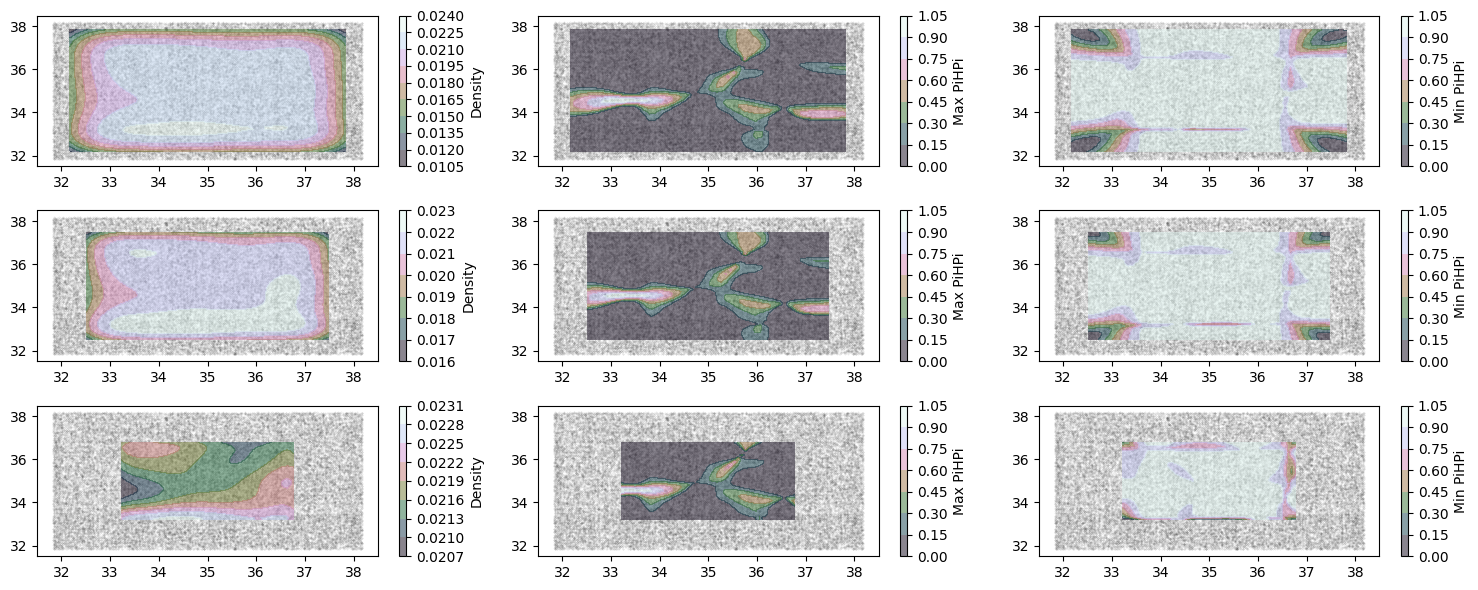

In [7]:
fig, ax=plt.subplots(nrows=3, figsize=(5*3, 2*3),ncols=3)

for idx in range(0, 3):
    v=vs[idx]
    ax[idx][0].scatter(data[:,0], data[:,1], s=.1, alpha=0.1, c='k')
    c=ax[idx][0].contourf(v['meshgrid'][0],v['meshgrid'][1], v['density'], alpha=0.5, cmap='cubehelix')
    #ax[idx][0].contour(v['meshgrid'][0],v['meshgrid'][1], v['density'], alpha=0.5, cmap='cubehelix')
    plt.colorbar(c, label='Density')
    ax[idx][1].scatter(data[:,0], data[:,1], s=.1, alpha=0.1, c='k')
    c=ax[idx][1].contourf(v['meshgrid'][0],v['meshgrid'][1], v['max_eigen'],  alpha=0.5,cmap='cubehelix')
    plt.colorbar(c, label='Max PiHPi')
    ax[idx][-1].scatter(data[:,0], data[:,1], s=.1, alpha=0.1, c='k')
    c=ax[idx][-1].contourf(v['meshgrid'][0],v['meshgrid'][1], v['min_eigen'], alpha=0.5, cmap='cubehelix')
    plt.colorbar(c, label='Min PiHPi')
plt.tight_layout()
plt.savefig('../figures/diagnostics_bck.jpeg')

In [8]:
bw=0.7
data=np.array(d['streamgap']['data']).T
v0=get_density(data, padding=0., bw=bw, nboot=5)
v1=get_density(data, padding=bw, bw=bw, nboot=5)
v2=get_density(data, padding=2*bw, bw=bw, nboot=5)



/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/findthegap/gapper.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_t = torch.tensor(points, dtype=torch.float32, requires_grad=requires_grad)


In [9]:
vs=[v0, v1, v2]

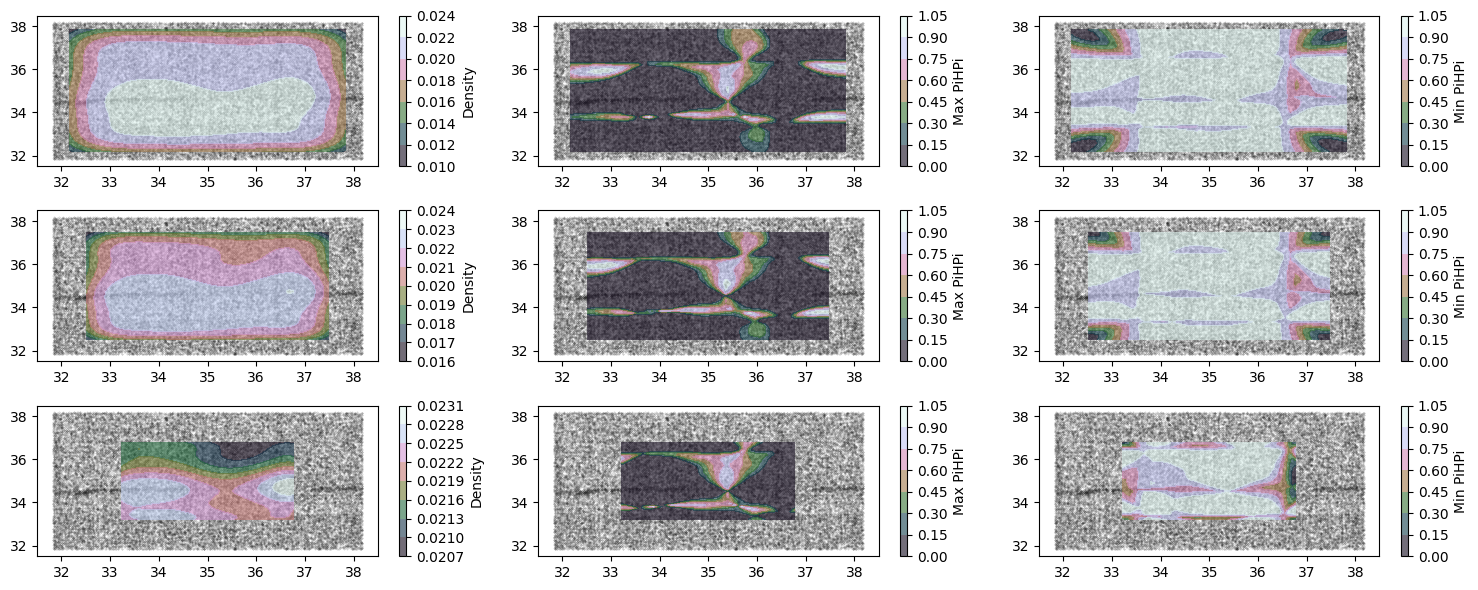

In [11]:
fig, ax=plt.subplots(nrows=3, figsize=(5*3, 2*3),ncols=3)

for idx in range(0, 3):
    v=vs[idx]
    ax[idx][0].scatter(data[:,0], data[:,1], s=.1, alpha=0.2, c='k')
    c=ax[idx][0].contourf(v['meshgrid'][0],v['meshgrid'][1], v['density'], alpha=0.6, cmap='cubehelix')
    #ax[idx][0].contour(v['meshgrid'][0],v['meshgrid'][1], v['density'], alpha=0.5, cmap='cubehelix')
    plt.colorbar(c, label='Density')
    ax[idx][1].scatter(data[:,0], data[:,1], s=.1, alpha=0.2, c='k')
    c=ax[idx][1].contourf(v['meshgrid'][0],v['meshgrid'][1], v['max_eigen'],  alpha=0.6,cmap='cubehelix')
    plt.colorbar(c, label='Max PiHPi')
    ax[idx][-1].scatter(data[:,0], data[:,1], s=.1, alpha=0.2, c='k')
    c=ax[idx][-1].contourf(v['meshgrid'][0],v['meshgrid'][1], v['min_eigen'], alpha=0.6, cmap='cubehelix')
    plt.colorbar(c, label='Min PiHPi')
plt.tight_layout()
plt.savefig('../figures/diagnostics_st.jpeg')